CLIP requires strong text encoder and image encoder.

The text encoder is a simple transformer but the image encoder is a ResNet and the ViT transformer.


Zero Shot CLIP has performed better than supervised linear classifier using ResNet.

But the question is : is it useful only for classification.


In [1]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

In [1]:
import numpy as np
import torch
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [39]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel
from PIL import Image

def load_vocab(n=20000):
    url = "https://raw.githubusercontent.com/first20hours/google-10000-english/master/20k.txt"
    vocab = requests.get(url).text.splitlines()[:n]
    return vocab

vocab = load_vocab()
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# image = Image.open("/home/shataxi.dubey/shataxi_work/vlm_on_planet/UP_Zoom_17.png")
image = Image.open('/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yoloe/dog.jpeg')

inputs = processor(text=vocab, images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
probs


tensor([[4.2671e-05, 3.8640e-05, 6.4757e-05,  ..., 7.2597e-05, 8.6144e-06,
         4.5607e-06]], grad_fn=<SoftmaxBackward0>)

In [40]:
x = probs.sort()
print(x.values[0][-5:])
x.indices[0][-5:]

tensor([0.0088, 0.0095, 0.0099, 0.0181, 0.0457], grad_fn=<SliceBackward0>)


tensor([15680, 14395, 19485,  8170, 10754])

In [42]:
vocab[10754]

'backpack'

Load the models

In [2]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

RN50x64
Model parameters: 623,258,305
Input resolution: 448
Context length: 77
Vocab size: 49408

ViT-B/32
Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408

In [3]:
model, preprocess = clip.load('ViT-L/14')
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


In [4]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f24130a7f60>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [5]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch
import glob

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
original_images = []
images = []
texts = []
region = 'lucknow_airshed_most_15'
# region = 'uttar_pradesh_most_15'
# region = 'west_bengal_most_15'

prompt0 = 'a image'
prompt1 = 'a satellite imagery'
prompt2 = 'brick kilns'
prompt3 = 'brick kiln with chimney'
prompt4 = 'A satellite imagery of a brick kiln'
prompt5 = 'rectangular object with chimney'
prompt6 = 'brick kilns'
prompt7 = 'a satellite imagery'
prompt8 = 'satellite imagery of fields'
prompt9 = 'fields, factories, roads and brick kilns'
prompt10 = 'fields, factories, roads'
prompt11 = 'A satellite imagery of brick factories'
prompt12 = 'A satellite imagery of brick kilns'
prompt13 = 'satellite imagery of fields factories and brick kilns'
prompt14 = 'satellite imagery of fields and factories'
prompt15 = 'fields and factories'
prompt16 = 'A satellite imagery of a brick kiln'
prompt17 = 'Brick kiln in Lucknow'
prompt18 = 'A satellite imagery of'
prompt19 = 'A photo of a brick kiln'
prompt20 = 'A satellite imagery of a brick kiln in Lucknow'
prompt21 = 'A satellite imagery of a brick kiln with chimney in Lucknow'
# prompt22 = 'A satellite imagery of a brick kiln with chimney in Lucknow, India'
prompt23 = 'A satellite imagery of a brick kiln with chimney'
prompt24 = 'A satellite imagery of a brick kiln with chimney in West Bengal'
prompt25 = 'A satellite imagery of a brick kiln in daytime'
prompt26 = 'A satellite imagery of Lucknow'
# superresolution images /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/uttar_pradesh_most_15/swinir_images
# image_paths = glob.glob(f'/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/{region}/swinir_images/*')
# image_paths = glob.glob(f'/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/{region}/images/*')
image_paths = glob.glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/train/images/*')
for image in image_paths[:10]:
    image = Image.open(image).convert("RGB")
    original_images.append(image)
    images.append(preprocess(image))
    # image.save('/home/shataxi.dubey/shataxi_work/vlm_on_planet/tiff_to_png/im.png','PNG') # to store tiff in png format
texts += [prompt1, prompt3, prompt23, prompt21, prompt24]


In [7]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [8]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [9]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

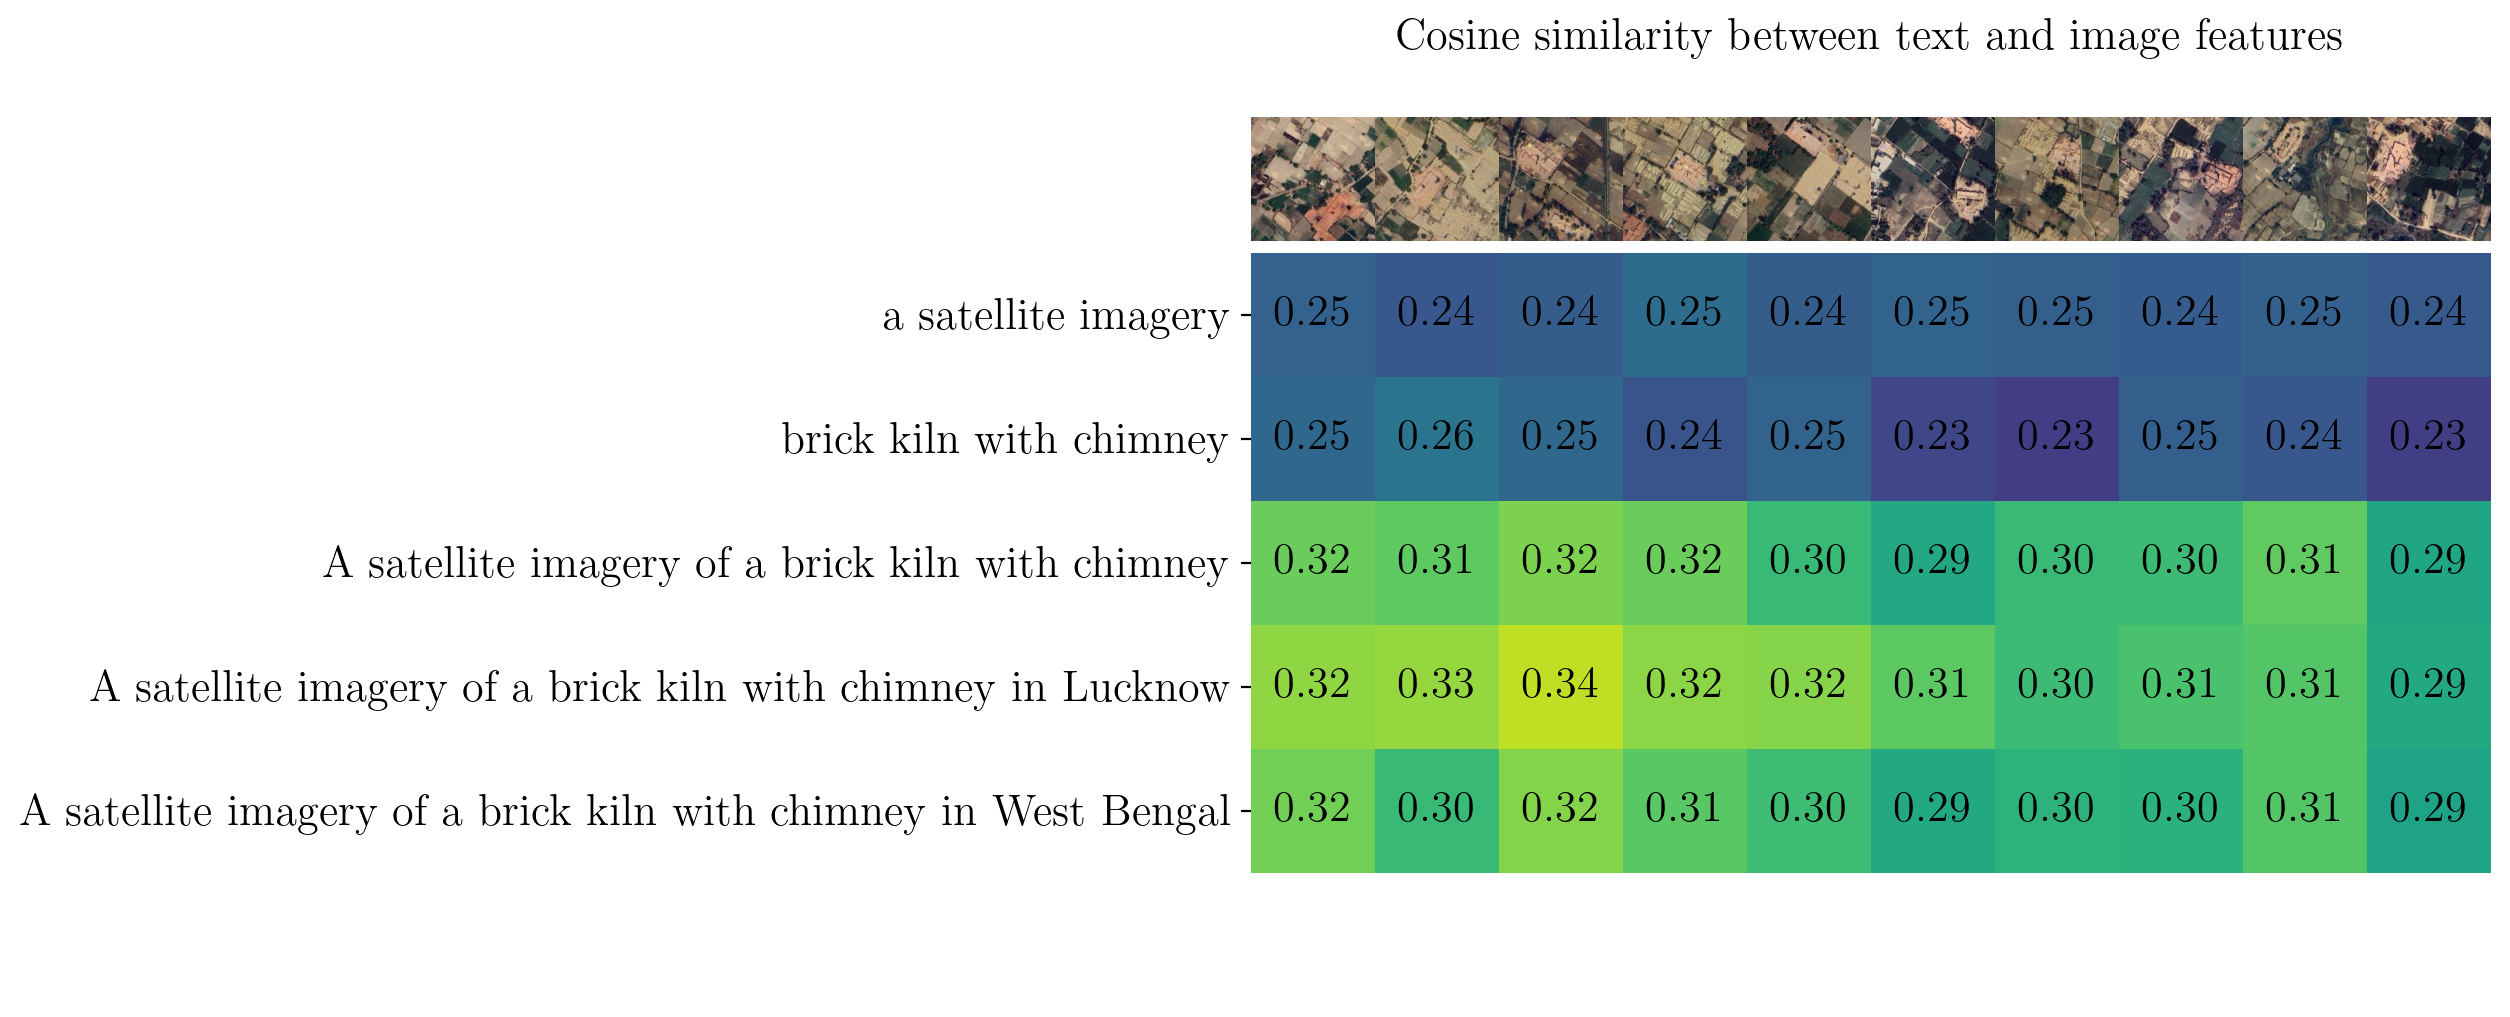

In [16]:
from astra.plot.utils import latexify
latexify(8,8,16)
count = len(texts)

# plt.figure(figsize=(8, 8))
plt.imshow(similarity, vmin=0.2, vmax=0.35) # vmin and vmax are used to set the colorbar lower and higher limit.

plt.yticks(range(count), texts)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6,-0.6), origin="lower") # origin = lower will put the (0,0) pixel of the image in the lower left corner. 
    # extent argument help in plotting multiple images , it takes (xmin, xmax, ymin, ymax), it will start putting the images from -0.5 to 14.5 and all images will be vertically present from -1.6 to 0.6
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center",)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, len(original_images) - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features")
# plt.savefig(f"clip2.png", bbox_inches='tight', dpi=300)

In [13]:
# chimneys, bricks, hospitals, power plants, windmills